## First, import the preprocessing modules

In [1]:
import sys
sys.path.append('../src')
from dataProcessing import add_to_dict, fit_cont, create_3_panel_plot
from scipy.io import readsav
import matplotlib.pyplot as plt
import numpy as np

## import an example datafile for debris disk HD 113766

In [2]:
data_dir = 'HD113766.sav' # This is from Mittal+15, 
# https://ui.adsabs.harvard.edu/abs/2015ApJ...798...87M/abstract

save_file = readsav(data_dir)
data_mittal = {}

# Create a dictionary and add the spectrum to the file
obid = 'HD113766'
data_mittal[obid] = {}
data_mittal = add_to_dict(save_file, data_mittal, obid)     

## Calculate the Stellar Photosphere Continuum and subtract it off from Disk spectrum

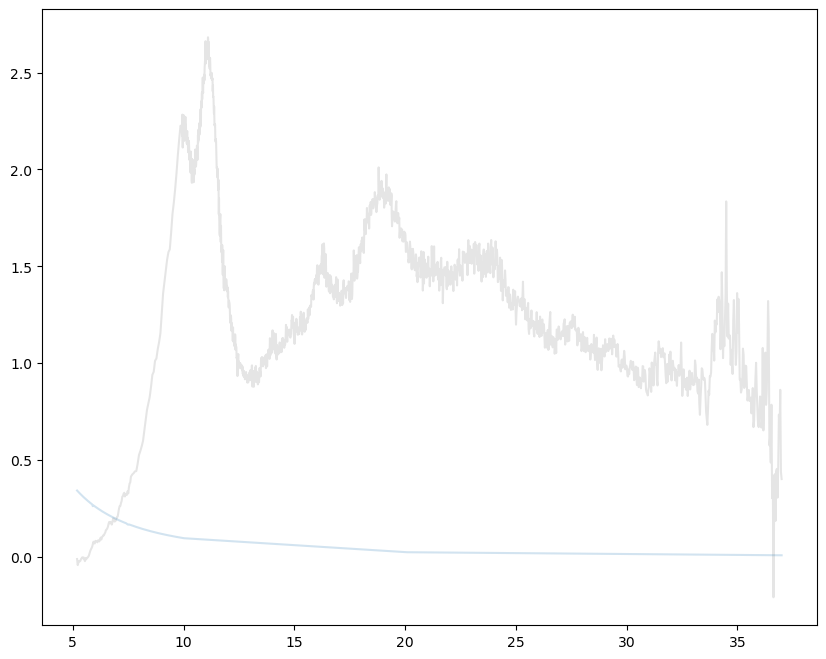

In [3]:
wave_grid = data_mittal['HD113766']['wave']

%matplotlib inline
ten_targets_final = []
ten_targets_10to15 = []

targets_w_model = []
plt.figure(figsize=(10,8))
for name in list(data_mittal.keys()):
    spectrum = data_mittal[name]
    if 'spec' in list(spectrum.keys()):
        if spectrum['spec'] is not None:
            ten_targets_final.append(name)
            if 'phot_fnu' in spectrum.keys() and spectrum['phot_fnu'] is not None:
                phot_flux = np.interp(spectrum['wave'], 
                                      spectrum['phot_wave'], 
                                      spectrum['phot_fnu']*spectrum['scale_photosphere_whole'])
                
                if spectrum['mips_24_factor_scaling']:
                    flux_cont_div = spectrum['spec']*spectrum['mips_24_factor_scaling']-phot_flux
                    plt.plot(spectrum['wave'], flux_cont_div, 
                             c='gray', alpha = 0.2)
                    plt.plot(spectrum['wave'], phot_flux, 
                             c='C0', alpha = 0.2)
                    data_mittal[name]['IRS_cont_div'] = flux_cont_div
                else:
                    flux_cont_div = spectrum['spec']-phot_flux
                    plt.plot(spectrum['wave'], flux_cont_div, 
                         c='gray', alpha = 0.2)
                    data_mittal[name]['IRS_cont_div'] = flux_cont_div
                targets_w_model.append(name)
plt.show()

HD113766
0.13720302610530455
I am here.


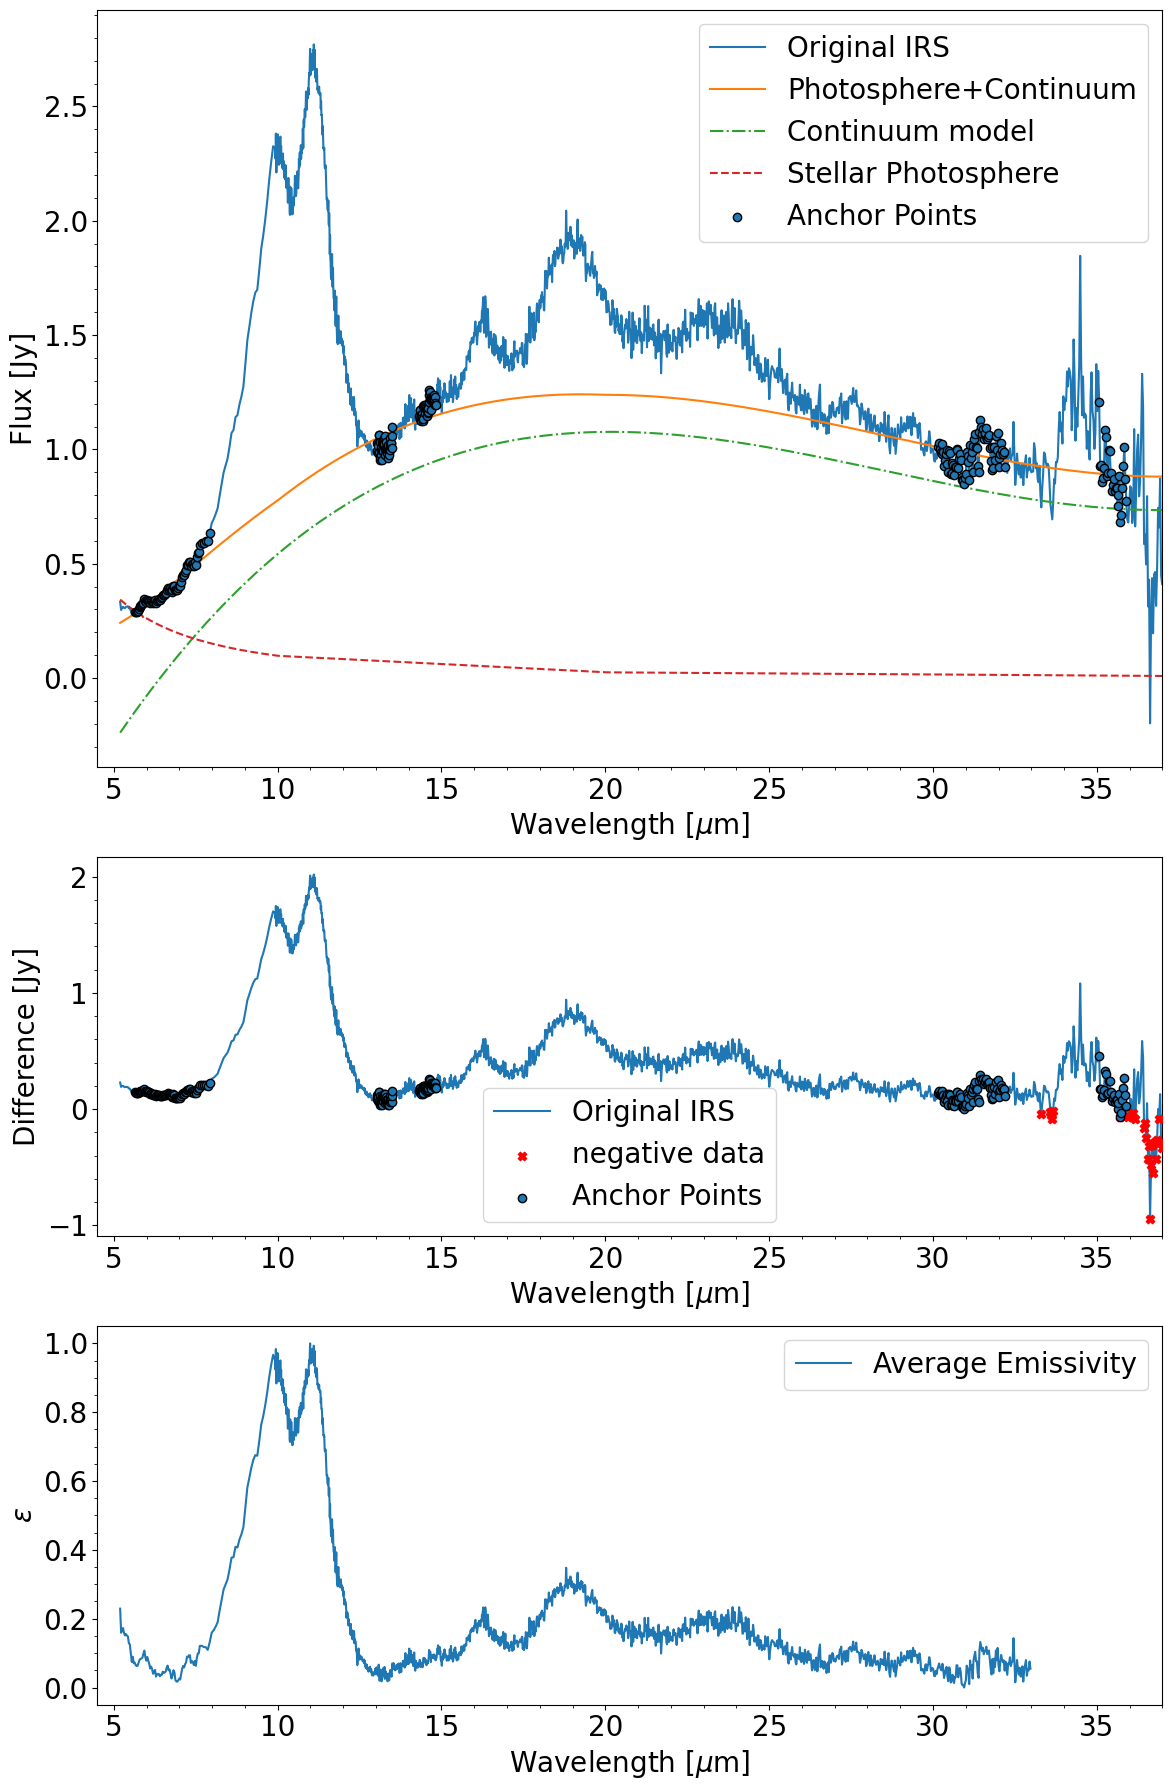

In [4]:
wave_grid = data_mittal['HD113766']['wave']


# marker_top_list = ['-', '-', '-.', '--', 'o']
# marker_middle_list = ['-', 'o']
# marker_bottom_list = ['-']

%matplotlib inline
for name in data_mittal.keys():
    print(name)
    spectrum = data_mittal[name]
    mask = []
    neg_mask = []
    _, _, _, _,  anchor_x, anchor_y, mask = fit_cont(spectrum, wave_grid, flux_downSamp_switch = False, 
                              regions = [(5.61, 7.94), (13.02, 14.83), (30.16, 32)],
                              order = 3)
    wave, cont, old, diff_per, anchor_x_ori, anchor_y_ori, mask_ori = fit_cont(spectrum, wave_grid, flux_downSamp_switch = False, 
                      regions = [(5.61, 7.94), (13.02, 13.50), (14.32, 14.83), (30.16, 32.19), (35.07, 35.92)],
                      order = 3)



    new_diff= old-cont
    cont_offset = np.abs(np.min(new_diff[mask])) # dynamically determine offset, with the largest negative value
    print(cont_offset)
    
    ori_flux = spectrum['spec']*spectrum['mips_24_factor_scaling']
#     photo_flux = spectrum['phot_fnu']*spectrum['scale_photosphere_whole']
    phot_flux = np.interp(spectrum['wave'], 
                                      spectrum['phot_wave'], 
                                      spectrum['phot_fnu']*spectrum['scale_photosphere_whole'])
                
    phot_flux_anchor = np.interp(anchor_x_ori, spectrum['phot_wave'], 
                                      spectrum['phot_fnu']*spectrum['scale_photosphere_whole'])
    ### Top Panel
    top_x_list = [wave, wave, wave, 
                  wave, 
                  anchor_x_ori]
    top_y_list = [ori_flux, 
                  cont+phot_flux, 
                  cont-cont_offset, 
                  phot_flux,#newly added photosphere
              anchor_y_ori+phot_flux_anchor]

    top_label_list = ['Original IRS', 'Photosphere+Continuum',  'Continuum model',
                      'Stellar Photosphere', 'Anchor Points']
    
    ### middle Panel
    new_diff_offsetted = new_diff+cont_offset
    middle_x_list = [wave, anchor_x_ori]
    middle_y_list = [new_diff_offsetted, new_diff_offsetted[mask_ori]]    
    middle_label_list = ['Original IRS', 'Anchor Points']
    
    
    ### bottom Panel
    temp = ori_flux/(cont+phot_flux)
    mask_33 = (wave<=33)
    bottom_x_list  = [wave[mask_33]]
    bottom_y_list = [(temp[mask_33]-np.min(temp[mask_33]))/np.max((temp[mask_33]-np.min(temp[mask_33])))]
    bottom_label_list = ['Average Emissivity']

    x_label_top = 'Wavelength [$\mu$m]'
    y_label_top = 'Flux [Jy]'
    x_label_middle = 'Wavelength [$\mu$m]'
    y_label_middle = 'Difference [Jy]'
    x_label_bottom = 'Wavelength [$\mu$m]'
    y_label_bottom = r'$\epsilon$'
    fontsize_dict = {'legend': 20, 'x_label': 20, 'y_label': 20, 'tick_labels': 20, 's':3}

    top_plot_method = ['line', 'line', 'line', 'line','scatter'] 
    middle_plot_method = ['line', 'scatter'] 
    bottom_plot_method = ['line'] 
    fontsize_dict = {'legend': 20, 'x_label': 20, 'y_label': 20, 'tick_labels': 20,  's':3}

#     save_subtracted to dataframe
    data_mittal[name]['IRS_cont_div_baseline'] = new_diff_offsetted
    data_mittal[name]['IRS_cont_div_norm_wave'] = wave
    print('I am here.')
    create_3_panel_plot(top_x_list, top_y_list, middle_x_list, middle_y_list,bottom_x_list, bottom_y_list,
                         top_label_list, middle_label_list,bottom_label_list,
                         x_label_top, y_label_top, x_label_middle, y_label_middle,
                         x_label_bottom, y_label_bottom, fontsize_dict,
                         top_plot_method=top_plot_method, 
                         middle_plot_method=middle_plot_method, 
                         bottom_plot_method=bottom_plot_method,
#                          save_path='../D_output/continuum fit/'+name+'s'+'.pdf', ##can save the output
                        negative_data_switch=1, xmin=4.5, xmax=37)

## Export the emissivity Spectrum that we generated for futher analyses

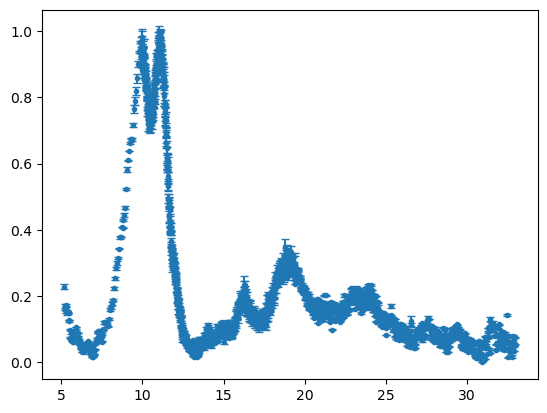

In [5]:
mask_33 = (wave<=33)
temp_flux = (temp-np.min(temp[mask_33]))/np.max((temp[mask_33]-np.min(temp[mask_33])))
em_unc =  data_mittal['HD113766']['specerr'][mask_33]/ data_mittal['HD113766']['spec'][mask_33]*temp_flux[mask_33]
plt.errorbar(wave[mask_33], 
             temp_flux[mask_33], 
             yerr = em_unc, 
             capsize=3,
             fmt = 'o', ms=3)
fout = np.column_stack((wave[mask_33], temp_flux[mask_33], em_unc))
np.savetxt('HD113766_em.txt', fout)